In [1]:
## splines; forwards
from __future__ import division
import numpy as np
import pandas as pd
import math
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import sys
import os
os.chdir('C:/BankRisk')

In [2]:
ls = pd.read_csv('LibSwap_LongHist_30y_201712.csv',index_col=0)
ls.index = pd.to_datetime(ls.index)
ls.dropna(axis=0,how='all',inplace=True)
lscol= list(ls.columns)
ls.tail()

F1d      L1m      L3m      L6m     L12m       S1y       S2y  \
Date                                                                       
2017-08-01  1.16  1.23177  1.31418  1.45370  1.72534  1.457261  1.577304   
2017-09-01  1.15  1.23492  1.32330  1.47322  1.73825  1.496600  1.624650   
2017-10-01  1.15  1.23855  1.36079  1.54196  1.82086  1.611476  1.787857   
2017-11-01  1.16  1.28788  1.43420  1.62646  1.90157  1.710476  1.881905   
2017-12-01  1.30  1.48504  1.60175  1.76804  2.04349  1.858800  2.037300   

                 S3y       S4y       S5y       S7y      S10y      S30y  Prime  \
Date                                                                            
2017-08-01  1.676130  1.762826  1.844391  1.993391  2.163652  2.460870   4.25   
2017-09-01  1.718500  1.795650  1.866550  1.999050  2.156200  2.440900   4.25   
2017-10-01  1.901905  1.984190  2.053810  2.178000  2.322190  2.568333   4.25   
2017-11-01  1.985524  2.056762  2.114190  2.217619  2.341714  2.564429   4.25   
2017-12-01  2.132900  2.187778  2.234350  2.308750  2.402000  2.564100   4.40   

            L9m  
Date             
2017-08-01  NaN  
2017-09-01  NaN  
2017-10-01  NaN  
2017-11-01  NaN  
2017-12-01  NaN

In [3]:
def cs(y, xtm=10, frq=12):
  # assume y=yield curve, 2 cols: mat & yld

  if type(y) != pd.core.frame.DataFrame:
    return('Error: need a data frame')

  if len(list(y.columns))!= 2:
    return('Error: need 2 column dataframe: maturity & yield')

  ns = len(y)-1  # ns is # of line segments (=#nodes-1)

  if ns < 2:
    return('Error: need bigger yield curve')

  y.columns = ['m','x']
  if y['m'].max() < xtm: xtm = y['m'].max()
  mxt = y['m'].max()

  A = pd.DataFrame(np.zeros([4 * ns,4 * ns]))  # 4 coeff for cubic eqns

  for i in np.arange(ns):
    for j in np.arange(4):
      A.ix[i,4*i + j] = y.ix[i+1,'m']**j   # right-hand ends
      A.ix[ns+i,4*i + j] = y.ix[i,'m']**j  # left-hand ends

  for i in np.arange(ns-1):
    for j in np.arange(1,4):  # first derivatives
      A.ix[2*ns+i,4*i + j] = j*y.ix[i+1,'m']**(j-1)
      A.ix[2*ns+i,4*(i+1) + j] = -j*y.ix[i+1,'m']**(j-1)
    for k in np.arange(3,5):  # second derivatives
      A.ix[3*ns+i-1,4*i+k-1]=math.factorial(k-1)*y.ix[i+1,'m']**(k-3)
      A.ix[3*ns+i-1,4*(i+1)+k-1]=-math.factorial(k-1)*y.ix[i+1,'m']**(k-3)
    A.ix[4*ns-2,2] = 2  # far left-hand end
    A.ix[4*ns-1, 4*ns-2] = 2  # far right-hand end (with next row)
    A.ix[4*ns-1, 4*ns-1] = 6*y.ix[ns,'m']

  B = pd.DataFrame(np.zeros(4*ns))

  for i in np.arange(ns):
    B.ix[i] = y.ix[i+1,'x']
    B.ix[ns+i] = y.ix[i,'x']

  z = np.linalg.solve(np.array(A),np.array(B))  # solve linear eqns
  zs=pd.DataFrame(pd.DataFrame(z).values.reshape([ns,4]))  # create coef matrix
  cn = list(zs.columns)
  zs['Strt'] = y['m']
  zs['End'] = y['m'].shift(-1)
  zs = zs[['Strt','End']+cn]

  sp = set(np.arange(0,(mxt*frq+1))/frq)  # gather all maturities to output
  sp.update(y['m'])            # include any 'oddball' maturities from original yield curve
  sp = sorted(sp)
  sp = pd.DataFrame(sp)   # create output dataframe
  sp.columns = ['ms']     # column of maturities
  sp = sp[sp['ms']<=xtm]
  sp['xs'] = 0.0          # col of interpolated rates

  rw = 0
  for i in np.arange(len(sp)):  # calculate spline rates from coeffs
    while sp.ix[i]['ms'] > zs.ix[rw]['End']: rw = rw + 1
    sp.ix[i,'xs'] = zs.ix[rw,0] + zs.ix[rw,1]*sp.ix[i,'ms'] +\
                    zs.ix[rw,2]*sp.ix[i,'ms']**2 + zs.ix[rw,3]*sp.ix[i,'ms']**3

  return sp

In [4]:
def qs(y, xtm=10, frq=12):  ## quartic spline function
  # assume y=yield curve, 2 cols: mat & yld

  if type(y) != pd.core.frame.DataFrame:
    return('Error: need a data frame')

  if len(list(y.columns))!= 2:
    return('Error: need 2 column dataframe: maturity & yield')

  ns = len(y)-1  # ns is # of line segments (=#nodes-1)

  if ns < 2:
    return('Error: need bigger yield curve')

  y.columns = ['m','x']
  if y['m'].max() < xtm: xtm = y['m'].max()
  mxt = y['m'].max()

  Q = pd.DataFrame(np.zeros([5 * ns,5 * ns]))  # 4 coeff for cubic eqns

  for i in np.arange(ns):
    for j in np.arange(5):
      Q.ix[i,5*i+j] = y.ix[i+1,'m']**j  # right-hand ends
      Q.ix[ns+i,5*i+j] = y.ix[i,'m']**j # left-hand ends

  for i in np.arange(ns-1):
    ## 1st derivatives:
    for j in np.arange(1,5):
      Q.ix[2*ns+i,5*i+j] = j*y.ix[i+1,'m']**(j-1)
      Q.ix[2*ns+i,5*(i+1)+j] = -j*y.ix[i+1,'m']**(j-1)
    ## 2nd derivatives:
    for k in np.arange(2,5):
      if k==4:
        kt=.5
      else:
        kt=1
      Q.ix[3*ns+i-1,5*i+k] = math.factorial(k)*kt*y.ix[i+1,'m']**(k-2)
      Q.ix[3*ns+i-1,5*(i+1)+k] = -math.factorial(k)*kt*y.ix[i+1,'m']**(k-2)
    ## 3rd derivatives:
    for h in np.arange(3,5):
      Q.ix[4*ns+i-2,5*i+h] = math.factorial(h)*y.ix[i+1,'m']**(h-3)
      Q.ix[4*ns+i-2,5*(i+1)+h] = -math.factorial(h)*y.ix[i+1,'m']**(h-3)

    # far left-hand end (1 eqn)
    Q.ix[5*ns-3,2]  = 2

    # far right-hand end (1 eqn) instantaneously straight (2nd deriv = 0)
    Q.ix[5*ns-2, 5*ns-3] = 2
    Q.ix[5*ns-2, 5*ns-2] = 6*y.ix[ns,'m']
    Q.ix[5*ns-2, 5*ns-1] = 12*y.ix[ns,'m']**2

    # far right-hand end (3rd deriv = 0) NEW!!!! (instead of 1st deriv = 0)    
    Q.ix[5*ns-1, 5*ns-2] = 6
    Q.ix[5*ns-1, 5*ns-1] = 24*y.ix[ns,'m']

  R = np.zeros(5*ns)
  for i in np.arange(ns):
    R[i] = y.ix[i+1,'x']
    R[ns+i] = y.ix[i,'x']

  s = np.linalg.solve(np.array(Q),np.array(R))  # solve linear eqns
  ss=pd.DataFrame(pd.DataFrame(s).values.reshape([ns,5]))  # create coef matrix
  sscol = list(ss.columns)
  ss['Strt'] = y['m']
  ss['End'] = y['m'].shift(-1)
  ss = ss[['Strt','End']+sscol]

  sq = set(np.arange(0,(mxt*frq+1))/frq)  # gather all maturities to output
  sq.update(y['m'])            # include any 'oddball' maturities from original yield curve
  sq = sorted(sq)
  sq = pd.DataFrame(sq)   # create output dataframe
  sq.columns = ['ms']     # column of maturities
  sq = sq[sq['ms']<=xtm]
  sq['xs'] = 0.0          # col of interpolated rates

  rw = 0
  for i in np.arange(len(sq)):  # calculate spline rates from coeffs
    while sq.ix[i]['ms'] > ss.ix[rw]['End']: rw = rw + 1
    sq.ix[i,'xs'] = ss.ix[rw,0] + ss.ix[rw,1]*sq.ix[i,'ms'] +\
                    ss.ix[rw,2]*sq.ix[i,'ms']**2 + ss.ix[rw,3]*sq.ix[i,'ms']**3 + ss.ix[rw,4]*sq.ix[i,'ms']**4

  return sq

In [5]:
def ccs(y, xtm=10, frq=12):  # constrained cubic spline
  # assume y=yield curve, 2 cols: mat & yld

  if type(y) != pd.core.frame.DataFrame:
    return('Error: need a data frame')

  if len(list(y.columns))!= 2:
    return('Error: need 2 column dataframe: maturity & yield')

  ns = len(y)-1  # ns is # of line segments (=#nodes-1)

  if ns < 2:
    return('Error: need bigger yield curve')

  y.columns = ['m','x']
  if y['m'].max() < xtm: xtm = y['m'].max()
  mxt = y['m'].max()

  C = pd.DataFrame(np.zeros([ns,7]))  # last 4 cols for cubic eqn coeffs (1st 3 for intermediate calcs)

  # internal node slopes:
  for i in np.arange(0,(ns-1)):
    if ((y.ix[i+2,'x']-y.ix[i+1,'x']==0)|(y.ix[i+1,'x']-y.ix[i,'x']==0)|\
       ((y.ix[i+2,'x']-y.ix[i+1,'x'])/(y.ix[i+1,'x']-y.ix[i,'x']+.000000001)<0)):
      C.ix[i,0] = 0
    else:
      C.ix[i,0] = 2/((y.ix[i+2,'m']-y.ix[i+1,'m'])/(y.ix[i+2,'x']-y.ix[i+1,'x'])+\
                    (y.ix[i+1,'m']-y.ix[i,'m'])/(y.ix[i+1,'x']-y.ix[i,'x']))

  # left-end slope: (held by m0)
  if y.ix[0,'x']==y.ix[1,'x']:
    m0 = 0
  else:
    m0 = (3*(y.ix[1,'x']-y.ix[0,'x'])/2/(y.ix[1,'m']-y.ix[0,'m'])-C.ix[0,0]/2)

  # right-end slopes:
  if y.ix[ns-1,'x']==y.ix[ns,'x']:
    C.ix[ns-1,0] = 0
  else:
    C.ix[ns-1,0] = (3*(y.ix[ns,'x']-y.ix[ns-1,'x'])/2/(y.ix[ns,'m']-y.ix[ns-1,'m'])-C.ix[ns-2,0]/2)

  # left-end 2nd derivs:
  for i in np.arange(1,ns):
    C.ix[i,1] =-2*(C.ix[i,0]+2*C.ix[i-1,0])/(y.ix[i+1,'m']-y.ix[i,'m'])+6*(y.ix[i+1,'x']-y.ix[i,'x'])/(y.ix[i+1,'m']-y.ix[i,'m'])**2

  # right-end 2nd derivs:
  i=0  ## special case for m0
  C.ix[i,2] = 2*(2*C.ix[i,0]+m0)/(y.ix[i+1,'m']-y.ix[i,'m'])-6*(y.ix[i+1,'x']-y.ix[i,'x'])/(y.ix[i+1,'m']-y.ix[i,'m'])**2

  for i in np.arange(1,ns-1):
    C.ix[i,2] = 2*(2*C.ix[i,0]+C.ix[i-1,0])/(y.ix[i+1,'m']-y.ix[i,'m'])-6*(y.ix[i+1,'x']-y.ix[i,'x'])/(y.ix[i+1,'m']-y.ix[i,'m'])**2

  # coefficients for solution:
  for i in np.arange(ns):
    C.ix[i,3] = (C.ix[i,2]-C.ix[i,1])/6/(y.ix[i+1,'m']-y.ix[i,'m'])  # D coeff
    C.ix[i,4] = (y.ix[i+1,'m']*C.ix[i,1]-y.ix[i,'m']*C.ix[i,2])/2/(y.ix[i+1,'m']-y.ix[i,'m'])  # C coeff
    C.ix[i,5] = ((y.ix[i+1,'x']-y.ix[i,'x'])-C.ix[i,4]*(y.ix[i+1,'m']**2-y.ix[i,'m']**2)-\
                 C.ix[i,3]*(y.ix[i+1,'m']**3-y.ix[i,'m']**3))/(y.ix[i+1,'m']-y.ix[i,'m'])  # B coeff
    C.ix[i,6] = y.ix[i,'x']-C.ix[i,5]*y.ix[i,'m']-C.ix[i,4]*y.ix[i,'m']**2-C.ix[i,3]*y.ix[i,'m']**3

  cC = list(C.columns)
  C['Strt'] = y['m']
  C['End'] = y['m'].shift(-1)
  C = C[['Strt','End']+cC]

  sp = set(np.arange(0,(mxt*frq+1))/frq)  # gather all maturities to output
  sp.update(y['m'])            # include any 'oddball' maturities from original yield curve
  sp = sorted(sp)
  sp = pd.DataFrame(sp)   # create output dataframe
  sp.columns = ['ms']     # column of maturities
  sp = sp[sp['ms']<=xtm]
  sp['xs'] = 0.0          # col of interpolated rates

  rw = 0
  for i in np.arange(len(sp)):  # calculate spline rates from coeffs
    while sp.ix[i]['ms'] > C.ix[rw]['End']: rw = rw + 1
    sp.ix[i,'xs'] = C.ix[rw,6] + C.ix[rw,5]*sp.ix[i,'ms'] +\
                    C.ix[rw,4]*sp.ix[i,'ms']**2 + C.ix[rw,3]*sp.ix[i,'ms']**3

  return sp

In [6]:
mlst = [0,1,3,6,12,24,36,48,60,84,120,360]
mlst = [x/12 for x in mlst]
mlst

[0.0, 0.08333333333333333, 0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 30.0]

In [7]:
if 'Prime' in ls.columns: lsx = ls.drop(['L9m','L12m','Prime'],axis=1)
## 365/360 accrual adjustment to full table: ###################
alst = [x for x in list(lsx.columns) if x[0:1]<'S']
lsx[alst] = lsx[alst]*365/360
lsx.tail(2)

F1d       L1m       L3m       L6m       S1y       S2y  \
Date                                                                     
2017-11-01  1.176111  1.305767  1.454119  1.649050  1.710476  1.881905   
2017-12-01  1.318056  1.505666  1.623997  1.792596  1.858800  2.037300   

                 S3y       S4y      S5y       S7y      S10y      S30y  
Date                                                                   
2017-11-01  1.985524  2.056762  2.11419  2.217619  2.341714  2.564429  
2017-12-01  2.132900  2.187778  2.23435  2.308750  2.402000  2.564100

In [8]:
#cchg = dict(zip(list(lsx.columns),mlst))
#lsx.rename(columns=cchg, inplace=True)
#lsx.head(2)

In [9]:
ydat = '2009-02-01'
yc2=pd.DataFrame(lsx.ix[ydat])
yc2.columns = ['xs']
yc2['ms'] = mlst
yc2 = yc2[['ms','xs']]
#yc2 = yc2[yc2['ms']<=10]
yc2.reset_index(drop=True,inplace=True)
yc2

ms        xs
0    0.000000  0.223056
1    0.083333  0.469208
2    0.250000  1.259889
3    0.500000  1.781342
4    1.000000  1.330000
5    2.000000  1.620000
6    3.000000  1.980000
7    4.000000  2.280000
8    5.000000  2.520000
9    7.000000  2.840000
10  10.000000  3.100000
11  30.000000  3.310000

In [10]:
yc2a = yc2.copy()
cs2 = cs(yc2a,xtm=30)
qs2 = qs(yc2a,xtm=30)
ccs2 = ccs(yc2a,xtm=30)
cs2.tail()

ms        xs
356  29.666667  3.315213
357  29.750000  3.313911
358  29.833333  3.312608
359  29.916667  3.311304
360  30.000000  3.310000

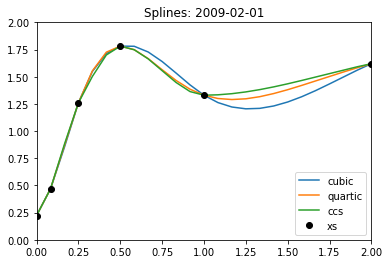

In [11]:
plt.plot(cs2['ms'],cs2['xs'],label='cubic')
plt.plot(qs2['ms'],qs2['xs'],label='quartic')
plt.plot(ccs2['ms'],ccs2['xs'],lw=1.5,label='ccs')
plt.plot(yc2['ms'],yc2['xs'],ls=' ',c='k',marker='o')
plt.title('Splines: '+ydat)
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend(loc=4)
plt.show()

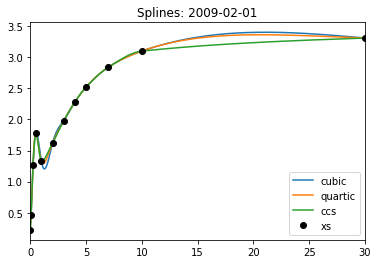

In [12]:
plt.plot(cs2['ms'],cs2['xs'],label='cubic')
plt.plot(qs2['ms'],qs2['xs'],label='quartic')
plt.plot(ccs2['ms'],ccs2['xs'],lw=1.5,label='ccs')
plt.plot(yc2['ms'],yc2['xs'],ls=' ',c='k',marker='o')
plt.title('Splines: '+ydat)
plt.xlim(0,cs2['ms'].max())
#plt.ylim(0,5)
plt.legend(loc=4)
plt.show()

In [13]:
cs2['xs'].max(), qs2['xs'].max(), ccs2['xs'].max(), yc2['xs'].max()

(3.4031826458536867,
 3.3627077651938371,
 3.3100000000000001,
 3.3100000000000001)

In [14]:
## dissect dfs_ccs():

In [15]:
yc = yc2a.copy()
yc

m         x
0    0.000000  0.223056
1    0.083333  0.469208
2    0.250000  1.259889
3    0.500000  1.781342
4    1.000000  1.330000
5    2.000000  1.620000
6    3.000000  1.980000
7    4.000000  2.280000
8    5.000000  2.520000
9    7.000000  2.840000
10  10.000000  3.100000
11  30.000000  3.310000

In [16]:
frq = 12       #
zeroto = .9999 #
if 1==1:       #
  xtm = yc['m'].max()
  yx = yc.copy()

  sp = ccs(yx,xtm=xtm, frq=frq)
  n = len(sp)
  df = pd.Series(np.zeros(n)) # holds df
  spt = pd.Series(np.zeros(n)) # holds spot

  # initialize sdf (sum of dfs), set first row to df=1, spt=ff rate
  sdf = 0
  df[0]= 1
  spt[0] = sp.ix[0,'xs']

  # process spot rates:
  for i in np.arange(1,n):
    if sp.ix[i,'ms'] > zeroto:
      pass
    else:
      df[i] = 1/(1+sp.ix[i,'xs']*sp.ix[i,'ms']/100) 
      spt[i]= (-100*np.log(df[i])/sp.ix[i,'ms'])

In [17]:
spt[0:14]

0     0.223056
1     0.469116
2     0.879386
3     1.257909
4     1.498651
5     1.693819
6     1.773456
7     1.739058
8     1.655162
9     1.546666
10    1.438360
11    1.354983
12    0.000000
13    0.000000
dtype: float64

In [18]:
if 1==1:
  ## process coupon periods:
  for i in np.arange(1,n):
    if sp.ix[i,'ms'] <= zeroto:
      pass
    else:
      fr=(6-sp.index[i]%6)*df[sp.index[i]%6] / 6
      sdf = df[0:i][df[0:i].index.to_series()%6==sp.index[i]%6].sum()
      if (sp.index[i]%6 == 0):
        fr=0
        sdf = sdf - 1 # need to remove 0 maturity df
      df[i] = (1 - (sdf - fr) * sp.ix[i, 'xs'] / 2 / 100) / ( 1 + sp.ix[i,'xs']/2/100)
      spt[i]=(-100*np.log(df[i])/sp.ix[i,'ms'])


In [19]:
df[10:15],spt[10:15]

(10    0.988085
 11    0.987656
 12    0.986846
 13    0.985715
 14    0.984501
 dtype: float64, 10    1.438360
 11    1.354983
 12    1.324110
 13    1.328124
 14    1.338919
 dtype: float64)

In [20]:
if 1==1:
  ## process coupon periods:
  for i in np.arange(1,n):
    if sp.ix[i,'ms'] <= zeroto:
      pass
    else:
      fr=(6-sp.index[i]%6)*df[sp.index[i]%6] / 6
      sdf = df[1:i][df[1:i].index.to_series()%6==sp.index[i]%6].sum()
#      if (sp.index[i]%6 == 0):
#        fr=0
#        sdf = sdf - 1 # need to remove 0 maturity df
      df[i] = (1 - (sdf - fr) * sp.ix[i, 'xs'] / 2 / 100) / ( 1 + sp.ix[i,'xs']/2/100)
      spt[i]=(-100*np.log(df[i])/sp.ix[i,'ms'])

In [21]:
df[10:15],spt[10:15]

(10    0.988085
 11    0.987656
 12    0.993452
 13    0.985715
 14    0.984501
 dtype: float64, 10    1.438360
 11    1.354983
 12    0.656928
 13    1.328124
 14    1.338919
 dtype: float64)

In [22]:
def dfs_ccs(yc, zeroto=.9999, frq=12):
  xtm = yc['m'].max()
  yx = yc.copy()

  sp = ccs(yx,xtm=xtm, frq=frq)
  n = len(sp)
  df = pd.Series(np.zeros(n)) # holds df
  spt = pd.Series(np.zeros(n)) # holds spot

  # initialize sdf (sum of dfs), set first row to df=1, spt=ff rate
  sdf = 0
  df[0]= 1
  spt[0] = sp.ix[0,'xs']

  # process spot rates:
  for i in np.arange(1,12):  # 1 to 11 month libor rates
    df[i] = 1/(1+sp.ix[i,'xs']*sp.ix[i,'ms']/100) 
    spt[i]= (-100*np.log(df[i])/sp.ix[i,'ms'])

  ## process coupon periods:
  for i in np.arange(12,n):
    fr=(6-sp.index[i]%6)*df[sp.index[i]%6] / 6
    sdf = df[0:i][df[0:i].index.to_series()%6==sp.index[i]%6].sum()
    if (sp.index[i]%6 == 0):
      fr=0
      sdf = sdf - 1 # need to remove 0 maturity df
    df[i] = (1 - (sdf - fr) * sp.ix[i, 'xs'] / 2 / 100) / ( 1 + sp.ix[i,'xs']/2/100)
    spt[i]=(-100*np.log(df[i])/sp.ix[i,'ms'])

  sp['df'] = df
  sp['spt'] = spt

  return sp

In [23]:
def dfs_cs(yc, zeroto=.9999):
  xtm = yc['m'].max()
  yx = yc.copy()

  sp = cs(yx,xtm=xtm)
  n = len(sp)
  df = pd.Series(np.zeros(n)) # holds df
  spt = pd.Series(np.zeros(n)) # holds spot

  # initialize sdf (sum of dfs), set first row to df=1, spt=ff rate
  sdf = 0
  df[0]= 1
  spt[0] = sp.ix[0,'xs']

  # process spot rates:
  for i in np.arange(1,12):  # 1 to 11 month libor rates
    df[i] = 1/(1+sp.ix[i,'xs']*sp.ix[i,'ms']/100) 
    spt[i]= (-100*np.log(df[i])/sp.ix[i,'ms'])

  ## process coupon periods:
  for i in np.arange(12,n):
    fr=(6-sp.index[i]%6)*df[sp.index[i]%6] / 6
    sdf = df[0:i][df[0:i].index.to_series()%6==sp.index[i]%6].sum()
    if (sp.index[i]%6 == 0):
      fr=0
      sdf = sdf - 1 # need to remove 0 maturity df
    df[i] = (1 - (sdf - fr) * sp.ix[i, 'xs'] / 2 / 100) / ( 1 + sp.ix[i,'xs']/2/100)
    spt[i]=(-100*np.log(df[i])/sp.ix[i,'ms'])
    
  sp['df'] = df
  sp['spt'] = spt

  return sp

In [24]:
def dfs_qs(yc, zeroto=.9999):
  xtm = yc['m'].max()
  yx = yc.copy()

  sp = qs(yx,xtm=xtm)
  n = len(sp)
  df = pd.Series(np.zeros(n)) # holds df
  spt = pd.Series(np.zeros(n)) # holds spot

  # initialize sdf (sum of dfs), set first row to df=1, spt=ff rate
  sdf = 0
  df[0]= 1
  spt[0] = sp.ix[0,'xs']

  # process spot rates:
  for i in np.arange(1,12):  # 1 to 11 month libor rates
    df[i] = 1/(1+sp.ix[i,'xs']*sp.ix[i,'ms']/100) 
    spt[i]= (-100*np.log(df[i])/sp.ix[i,'ms'])

  ## process coupon periods:
  for i in np.arange(12,n):
    fr=(6-sp.index[i]%6)*df[sp.index[i]%6] / 6
    sdf = df[0:i][df[0:i].index.to_series()%6==sp.index[i]%6].sum()
    if (sp.index[i]%6 == 0):
      fr=0
      sdf = sdf - 1 # need to remove 0 maturity df
    df[i] = (1 - (sdf - fr) * sp.ix[i, 'xs'] / 2 / 100) / ( 1 + sp.ix[i,'xs']/2/100)
    spt[i]=(-100*np.log(df[i])/sp.ix[i,'ms'])
    
  sp['df'] = df
  sp['spt'] = spt

  return sp

In [25]:
dccs = dfs_ccs(yc2a)
dcs = dfs_cs(yc2a)
dqs = dfs_qs(yc2a)
dccs[-4:]

ms        xs        df       spt
357  29.750000  3.308404  0.368129  3.359066
358  29.833333  3.308936  0.367022  3.359774
359  29.916667  3.309468  0.365923  3.360445
360  30.000000  3.310000  0.364829  3.361086

In [26]:
ydat

'2009-02-01'

In [27]:
dccs.to_csv('ps_ccs_'+ydat+'.csv')
dcs.to_csv('ps_cs_'+ydat+'.csv')
dqs.to_csv('ps_qs_'+ydat+'.csv')

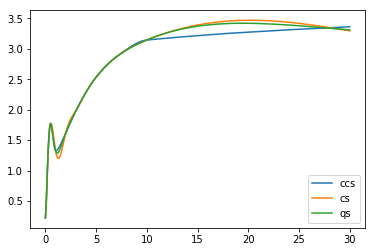

In [28]:
plt.plot(dccs['ms'],dccs['spt'],label='ccs')
plt.plot(dcs['ms'],dcs['spt'],label='cs')
plt.plot(dqs['ms'],dqs['spt'],label='qs')
plt.legend(loc=4)
plt.show()

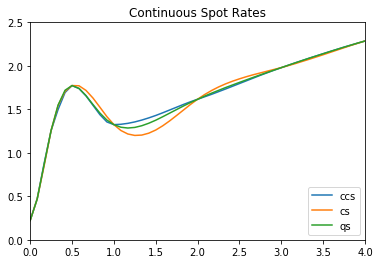

In [29]:
plt.plot(dccs['ms'],dccs['spt'],label='ccs')
plt.plot(dcs['ms'],dcs['spt'],label='cs')
plt.plot(dqs['ms'],dqs['spt'],label='qs')
plt.xlim(0,4)
plt.ylim(0,2.5)
plt.legend(loc=4)
plt.title('Continuous Spot Rates')
plt.show()

In [30]:
dccs.ix[360]['spt'],dcs.ix[360]['spt'],dqs.ix[360]['spt']

(3.3610858723109724, 3.2941307953663634, 3.3098531428456579)

In [31]:
yc2a

m         x
0    0.000000  0.223056
1    0.083333  0.469208
2    0.250000  1.259889
3    0.500000  1.781342
4    1.000000  1.330000
5    2.000000  1.620000
6    3.000000  1.980000
7    4.000000  2.280000
8    5.000000  2.520000
9    7.000000  2.840000
10  10.000000  3.100000
11  30.000000  3.310000

In [32]:
dccs.head(2)

ms        xs        df       spt
0  0.000000  0.223056  1.000000  0.223056
1  0.083333  0.469208  0.999609  0.469116

In [33]:
dccs2 = dccs.copy()

In [34]:
dcs2 = dcs.copy()

In [35]:
dqs2 = dqs.copy()

In [36]:
dccs2.to_csv('psf_ccs_'+ydat+'.csv')
dcs2.to_csv('psf_cs_'+ydat+'.csv')
dqs2.to_csv('psf_qs_'+ydat+'.csv')

In [37]:
## add forward rate forecast
dccs2.head(2)

ms        xs        df       spt
0  0.000000  0.223056  1.000000  0.223056
1  0.083333  0.469208  0.999609  0.469116

In [38]:
## testing for forwards:
#fm = 3
#fcol = 'fw'+str(fm)
#dccs[fcol] = dccs['df'].shift(-fm)  # put forward df into column, then finish calc in next line
#dccs[fcol] = dccs.apply(lambda x: -100*np.log(x[fcol]/x['df'])/(fm/12),axis=1)
#dccs.head(2)

In [39]:
## adds forward rate column:
def fwd(tbl,fm = 3):
  fcol = 'fw'+str(fm)
  tbl[fcol] = tbl['df'].shift(-fm)  # put forward df into column, then finish calc in next line
  tbl[fcol] = tbl.apply(lambda x: -100*np.log(x[fcol]/x['df'])/(fm/12),axis=1)
  return tbl

In [40]:
fwd(dccs2,3)
fwd(dccs2,60)
dccs2.head(2)

ms        xs        df       spt       fw3      fw60
0  0.000000  0.223056  1.000000  0.223056  1.257909  2.533204
1  0.083333  0.469208  0.999609  0.469116  1.841829  2.584514

In [41]:
fwd(dcs2,3)
fwd(dcs2,60)
dcs2.head(2)

ms        xs        df       spt       fw3      fw60
0  0.000000  0.223056  1.000000  0.223056  1.257909  2.533604
1  0.083333  0.469208  0.999609  0.469116  1.903077  2.585801

In [42]:
fwd(dqs2,3)
fwd(dqs2,60)  # run 4 times:  3, 12, 24, 60
dqs2.head(2)

ms        xs        df       spt       fw3      fw60
0  0.000000  0.223056  1.000000  0.223056  1.257909  2.533357
1  0.083333  0.469208  0.999609  0.469116  1.909904  2.586122

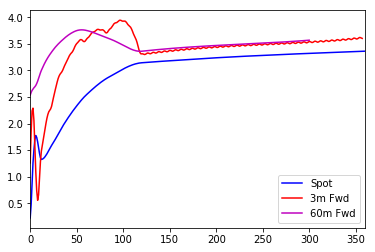

In [43]:
x = list(dccs2.index)
plt.plot(x,dccs2['spt'],c='b',label='Spot')
plt.plot(x,dccs2['fw3'],c='r',label='3m Fwd')
#plt.plot(x,dccs2['fw12'],c='g',label='12m Fwd')
plt.plot(x,dccs2['fw60'],c='m',label='60m Fwd')
plt.legend(loc=0)
plt.xlim(0,360)
plt.show()

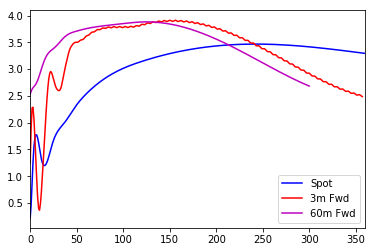

In [44]:
x = list(dcs2.index)
plt.plot(x,dcs2['spt'],c='b',label='Spot')
plt.plot(x,dcs2['fw3'],c='r',label='3m Fwd')
#plt.plot(x,dcs2['fw12'],c='g',label='12m Fwd')
plt.plot(x,dcs2['fw60'],c='m',label='60m Fwd')
plt.legend(loc=0)
plt.xlim(0,360)
plt.show()

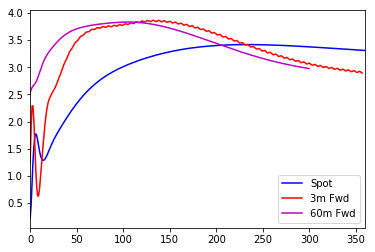

In [45]:
x = list(dqs2.index)
plt.plot(x,dqs2['spt'],c='b',label='Spot')
plt.plot(x,dqs2['fw3'],c='r',label='3m Fwd')
#plt.plot(x,dqs2['fw12'],c='g',label='12m Fwd')
plt.plot(x,dqs2['fw60'],c='m',label='60m Fwd')
plt.legend(loc=0)
plt.xlim(0,360)
plt.show()

In [46]:
## use 1995-02-01 as median
#data[data.performance==data.median()['performance']]

In [47]:
ls.ix['1995-02-01']

F1d      5.920000
L1m      6.115630
L3m      6.261720
L6m      6.545310
L12m     7.066410
S1y      7.071427
S2y      7.392686
S3y      7.485782
S4y      7.573178
S5y      7.640696
S7y      7.476400
S10y     7.835900
S30y     7.975900
Prime    9.000000
L9m      6.809770
Name: 1995-02-01 00:00:00, dtype: float64